In [2]:
import re
import numpy as np 
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
DATASET_COLUMNS = ['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/home/keerthana/training.1600000.processed.noemoticon.csv',encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
84337,0,1753573597,Sun May 10 02:19:14 PDT 2009,NO_QUERY,wyndwitch,@Soph4Soph thank you. I live with it back gro...
1070348,4,1966113690,Fri May 29 17:08:59 PDT 2009,NO_QUERY,tayalicia,"Tired from a LONG day at the waterpark, I love..."
1288194,4,2002454953,Tue Jun 02 04:15:48 PDT 2009,NO_QUERY,sunshinehollyyy,"@candice_ej nothing much, just watching gg and..."
402589,0,2057971717,Sat Jun 06 14:00:56 PDT 2009,NO_QUERY,DannysGhirl,@TheGodmutha mmmmmmmmmm danny naked would be e...
299479,0,1998019319,Mon Jun 01 17:51:23 PDT 2009,NO_QUERY,Jharule182,There is an error with twitter every post is ...


In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
print('length of data is',len(df))

length of data is 1600000


In [7]:
df.shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
np.sum(df.isnull().any(axis=1))

0

In [10]:
print('count of columns in the data is',len(df.columns))
print('count of rows in the data is',len(df))

count of columns in the data is 6
count of rows in the data is 1600000


In [11]:
df['target'].unique()

array([0, 4])

In [12]:
df['target'].nunique()

2

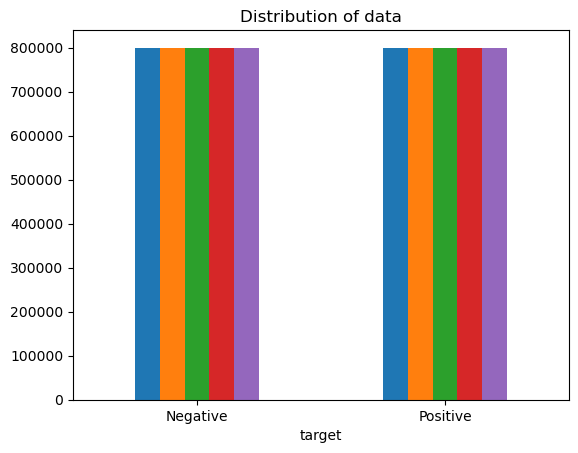

In [13]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

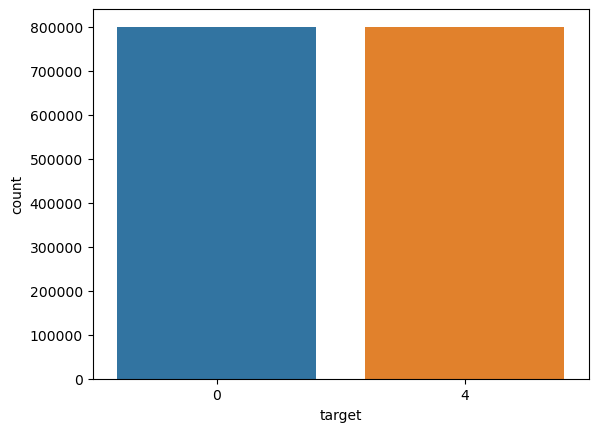

In [14]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [15]:
data=df[['text','target']]

In [51]:
data['target'].unique()

array([0, 4])

In [52]:
data_pos = data[data['target'] == 4]
data_neg = data[data['target'] == 0]

In [53]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [77]:
dataset = pd.concat([data_pos, data_neg])
print(dataset)

                                                     text  target
800000       I LOVE @Health4UandPets u guys r the best!!        4
800001  im meeting up with one of my besties tonight! ...       4
800002  @DaRealSunisaKim Thanks for the Twitter add, S...       4
800003  Being sick can be really cheap when it hurts t...       4
800004    @LovesBrooklyn2 he has that effect on everyone        4
...                                                   ...     ...
19995   Not much time off this weekend, work trip to M...       0
19996                           One more day of holidays        0
19997   feeling so down right now .. i hate you DAMN H...       0
19998   geez,i hv to READ the whole book of personalit...       0
19999   I threw my sign at donnie and he bent over to ...       0

[40000 rows x 2 columns]


In [78]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [104]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [105]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split()if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                     ['lovehealthuandpetsuguysrbest']
800001       ['immeetingonebestiestonightcantwaitgirltalk']
800002    ['darealsunisakimthankstwitteraddsunisagotmeet...
800003    ['sickreallycheaphurtsmucheatrealfoodplusfrien...
800004                      ['lovesbrooklyneffecteveryone']
Name: text, dtype: object

In [106]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

800000                         lovehealthuandpetsuguysrbest
800001           immeetingonebestiestonightcantwaitgirltalk
800002    darealsunisakimthankstwitteraddsunisagotmeethi...
800003    sickreallycheaphurtsmucheatrealfoodplusfriends...
800004                          lovesbrooklyneffecteveryone
Name: text, dtype: object

In [107]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].head()

800000                         lovehealthuandpetsuguysrbest
800001           immeetingonebestiestonightcantwaitgirltalk
800002    darealsunisakimthankstwitteraddsunisagotmeethi...
800003    sickreallycheaphurtsmucheatrealfoodplusfriends...
800004                          lovesbrooklyneffecteveryone
Name: text, dtype: object

In [108]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))','',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

800000                         lovehealthuandpetsuguysrbest
800001           immeetingonebestiestonightcantwaitgirltalk
800002    darealsunisakimthankstwitteraddsunisagotmeethi...
800003    sickreallycheaphurtsmucheatrealfoodplusfriends...
800004                          lovesbrooklyneffecteveryone
Name: text, dtype: object

In [109]:
import re
# Function to convert list to string
def list_to_string(lst):
    return ''.join(lst)
# Apply list_to_string function to 'text' column
dataset['text'] = dataset['text'].apply(list_to_string)
# Function to clean numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+','',data)
dataset['text'] = dataset['text'].apply(cleaning_numbers)
print(dataset['text'].head())

800000                         lovehealthuandpetsuguysrbest
800001           immeetingonebestiestonightcantwaitgirltalk
800002    darealsunisakimthankstwitteraddsunisagotmeethi...
800003    sickreallycheaphurtsmucheatrealfoodplusfriends...
800004                          lovesbrooklyneffecteveryone
Name: text, dtype: object


In [112]:
import re
from nltk.tokenize import RegexpTokenizer

# Function to convert list of lists to string
def list_to_string(lst):
    # Flatten the list of lists and join the strings
    flattened_list = [item for sublist in lst for item in sublist]
    return ''.join(flattened_list)

# Apply list_to_string function to 'text' column
dataset['text'] = dataset['text'].apply(list_to_string)

# Initialize RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Apply tokenizer to 'text' column
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

# Display tail of 'text' column
dataset['text'].head()


800000                       [lovehealthuandpetsuguysrbest]
800001         [immeetingonebestiestonightcantwaitgirltalk]
800002    [darealsunisakimthankstwitteraddsunisagotmeeth...
800003    [sickreallycheaphurtsmucheatrealfoodplusfriend...
800004                        [lovesbrooklyneffecteveryone]
Name: text, dtype: object

In [114]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                       [lovehealthuandpetsuguysrbest]
800001         [immeetingonebestiestonightcantwaitgirltalk]
800002    [darealsunisakimthankstwitteraddsunisagotmeeth...
800003    [sickreallycheaphurtsmucheatrealfoodplusfriend...
800004                        [lovesbrooklyneffecteveryone]
Name: text, dtype: object

In [118]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000                       [lovehealthuandpetsuguysrbest]
800001         [immeetingonebestiestonightcantwaitgirltalk]
800002    [darealsunisakimthankstwitteraddsunisagotmeeth...
800003    [sickreallycheaphurtsmucheatrealfoodplusfriend...
800004                        [lovesbrooklyneffecteveryone]
Name: text, dtype: object

In [119]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/keerthana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [121]:
X=data.text
y=data.target

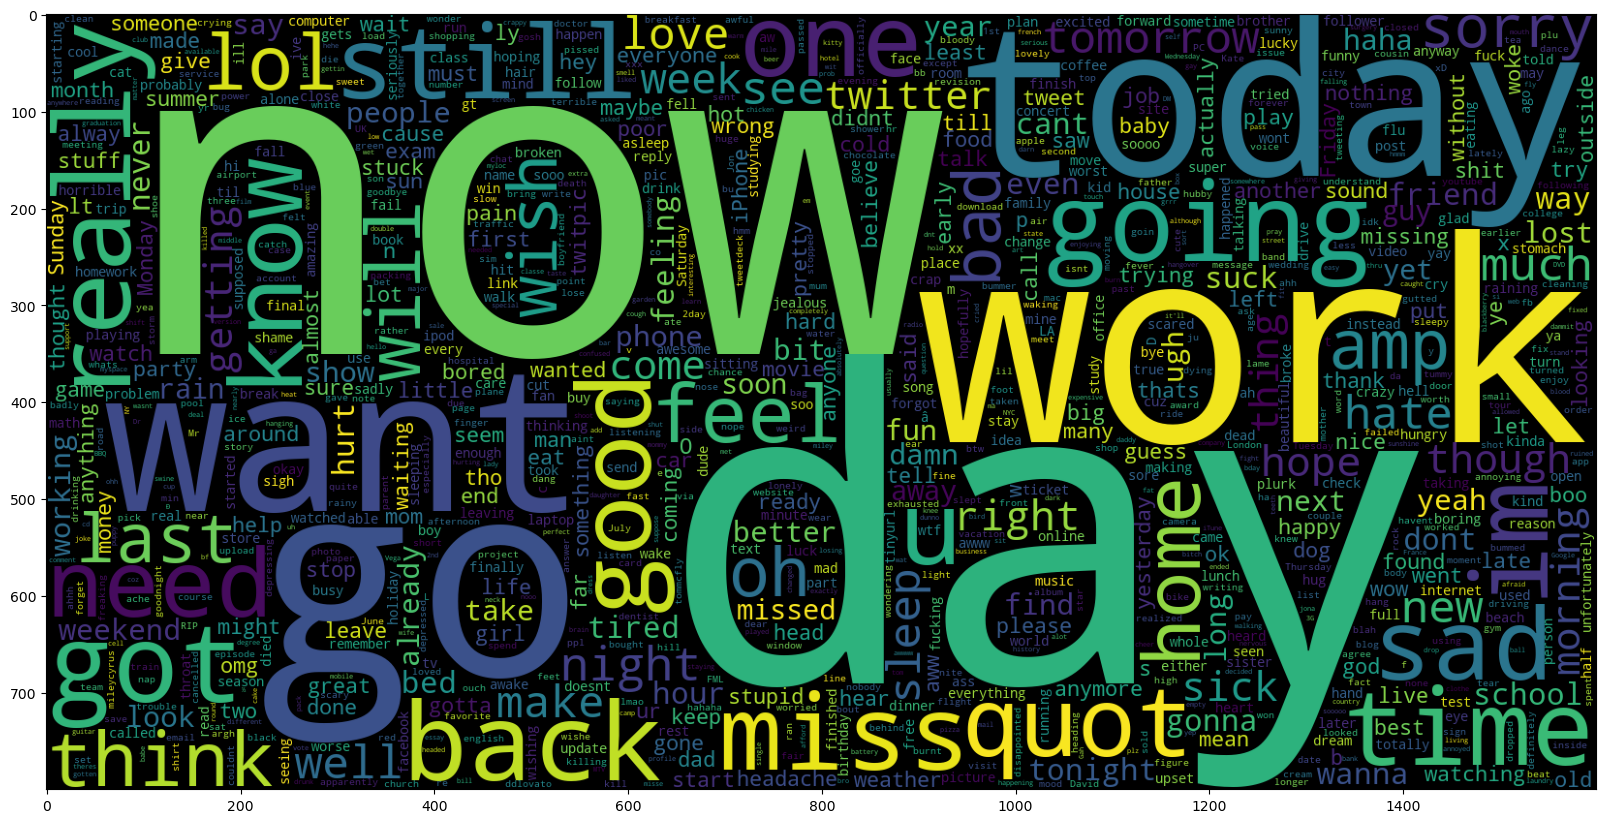

In [123]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

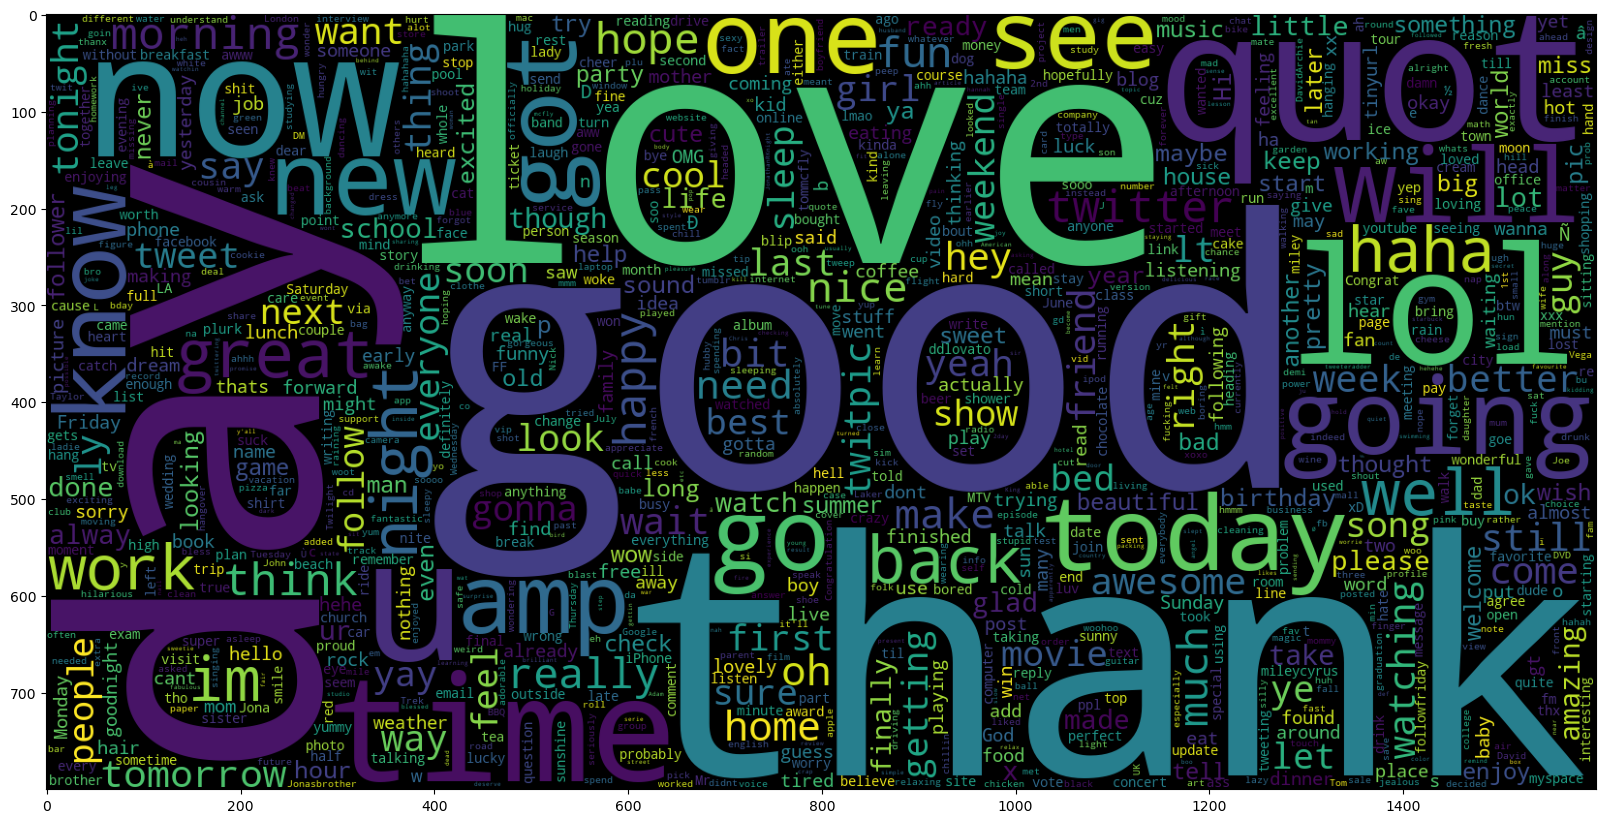

In [125]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [130]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [131]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [134]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           4       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



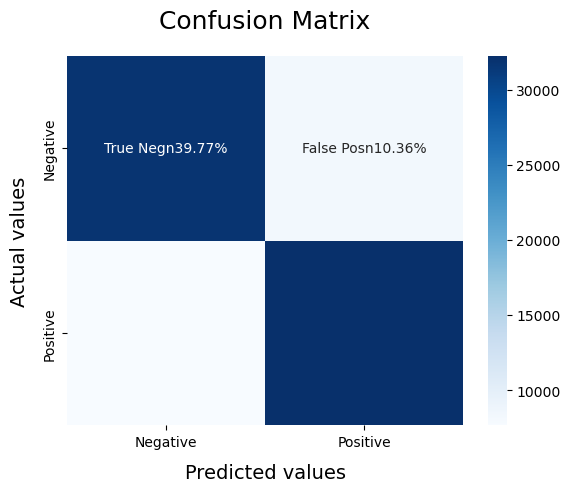

In [143]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

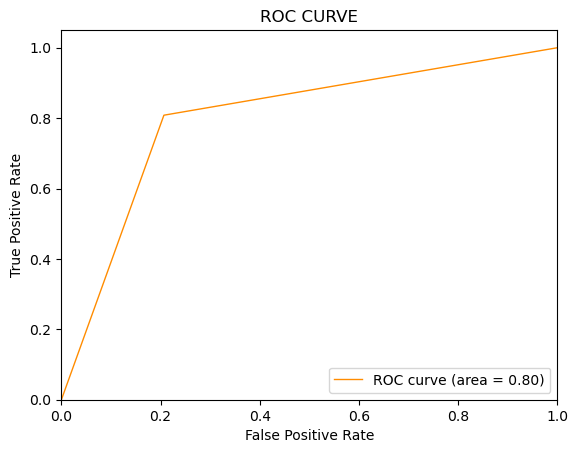

In [146]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1,pos_label=4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           4       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



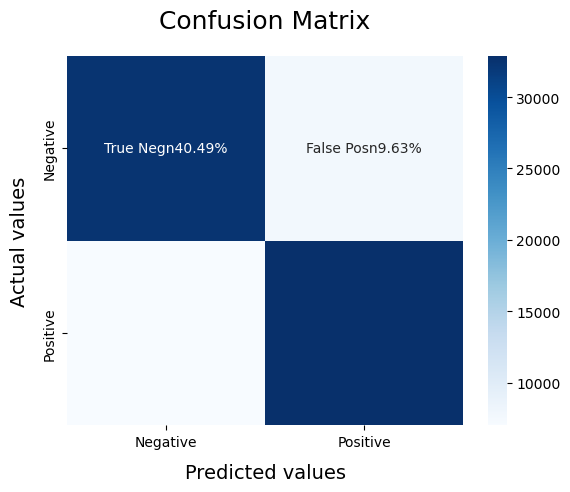

In [148]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

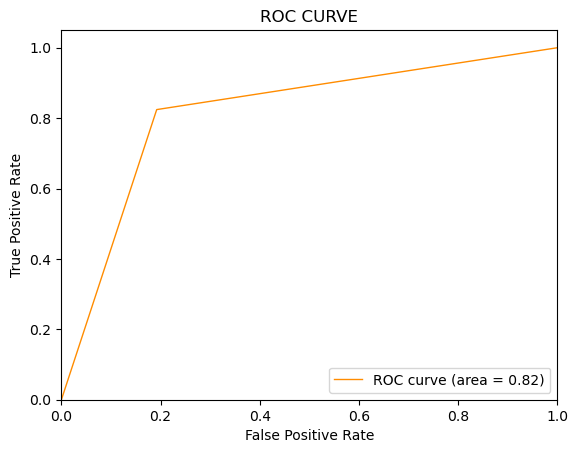

In [151]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2,pos_label=4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           4       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



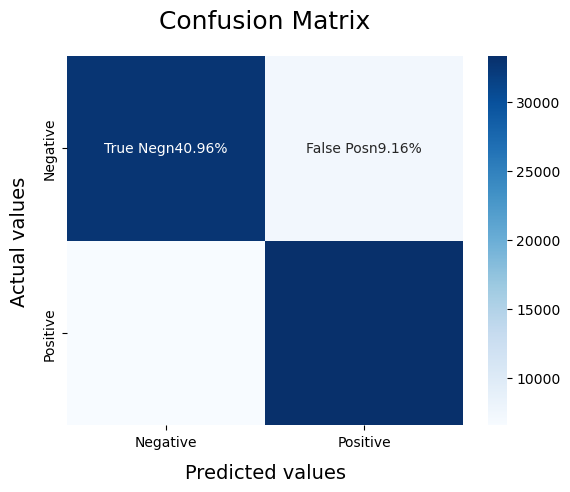

In [153]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

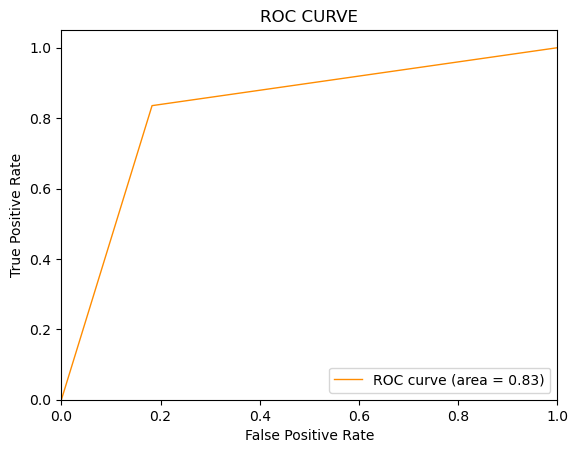

In [155]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3,pos_label=4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()